# HW3: (Regularized) Least square problem (65 pts)

In this assignment, you will write your own code to solve (regularized) least square problems. The least square problem is fundamental problem in engineering and many real world problems can be written as a least square problem (recall linear regression problem).

The least square problem is $$\mathop{\mathrm{minimize}}_{x\in\mathbb{R}^d} \|Ax-y\|_2^2$$ 

However, least square problem suffers computational disadvantages, especially when matrix $A$ is ill-conditioned. To overcome the computational issues, we usually consider regularized least square problem:
$$\mathop{\mathrm{minimize}}_{x\in\mathbb{R}^d} \|Ax-y\|_2^2 + \lambda \|x\|_2^2,$$
where $\lambda>0$ is called regularization parameter.

**In this assignment, you will be asked to write a solver for regularized least square problems.**

**More about regularization:** This is also a crucial technique in machine learning community, which can be used to overcome the overfitting issue. Overfitting means that your machine learning model works well in training dataset, but it fails to generalize. In this assignment, you will also explore this phenomenon by looking at polynomial regression.

**Methods for solving regularized least square problem:** Like standard least square problem, we have a nice explicit formula for the solution to regularized least square problem. We can also use GD/SGD to solve this problem.

## Mathematical backgrounds:

**Explicit formula:** The solution to regularized least square problem is $$ x = (A^\top A + \lambda I_d)^{-1}A^\top y,$$
where $I_d$ is identity matrix of shape $d\times d$.

**GD:** To implement GD, we should know the gradient of the objective function $f(x) = \|Ax-y\|_2^2 + \lambda \|x\|_2^2$. The gradient is $\nabla f = 2(A^\top A + \lambda I_d) x - 2(A^\top y)$

**SGD:** As we know, computing gradient using all samples is time consuming. Therefore, we use stochastic gradient descent to approximate the gradient. Suppose we want to use $b$ samples to approximate the gradient, i.e. batch size is $b$, the approximated gradient is 
$$ \nabla f \approx 2(A_b ^\top A_b + \lambda I_d) x - 2(A_b^\top y_b), $$
where $A_b$ is obtained by randomly selecting $b$ rows from $A$ (keep all columns), and $y_b$ contains the  corresponding values in $y$.

## Code instructions:

In this assignment, you will be asked to write a solver for regularized least square problem. The used mathematical formulas are given above. Feel free to contact me or ask your TA for help if the math is not clear.

For the coding part, you should do the following:
- You should write a class to construct the solver. Class name is given below. Your class should work for all regularized least square problem, i.e. all regularization parameter $\lambda$, matrix $A$, and vector $y$.
- The matrix $A$ must be a 2D numpy array and the vector must be a 1D numpy array. Your initialization should do the following:
    
    - If passing matrix is not a 2D numpy array, then you should print that the initialization fails because of the wrong shape of matrix.
    - If passing vector is not a 1D numpy array, then you should print that it is not a 1D numpy array. Then, you should reshape it to a 1D nupy array.
    - Denote the passing matrix and vector to be $A$ and $y$, respectively. You should also check that the number of rows in $A$ and the number of rows in $y$ are the same. Otherwise, the regularized least square problem is not well-defined mathematically. Check the number of rows, if they are not the same, then print that initialization fails because of the shape does not match.
    
- Write a method to solve (regularized) least square problem using `np.linalg.solve` command. You should include regularization parameter as an input. You should consider the following situations:
    - The default regularization should be 1.
    - If a negative parameter is given, then you should return error message saying that only nonnegative parameter can be used.
    - If regularization parameter is 0, then you should return least norm solution (please check lecture notes for the least norm solution).
    - If regularization parameter is None (`reg=None`), then you should return standard least square solution. 
    
- Write a method to solve (regularized) least square problem using GD/SGD. **In this method, you are not allowed to use if-else statement.** In other words, you do not need to check the condition that GD or SGD is applied.

- For GD/SGD method, the inputs are regularization parameter, max_iter, batch_size, and stepsize. The initial point of GD/SGD should be randomly selected. For each input:
    - regularization parameter is a nonnegative number. If a negative number is given, then you should return error message saying that only nonnegative parameter can be used. When regularization parameter is 0, then you solve standard least square problem. We do not consider least norm solution here.
    - max_iter is the total number of iterations. The default value is 100.
    - batch_size should be a positive integer. The default value is 2.
    - default stepsize is 0.01.

    
## Grading policy:

1. Your code passes all test examples. (20 pts)
2. You will also use your solver for applications. Details will be given below. (30 pts)
3. Docstrings (for all classes and methods) and inline comments are well-written. They should be at the right position. Please pay special attention to docstrings. Since numpy array shapes involve here. You should clearly explain the desired shapes. Moreover, all inputs and possible values should be well-explained. (10 pts)
4. Please restart the kernel and run all before you submit. (5 pts)

In [1]:

import numpy as np

class LinearSolver:
    
    def __init__(self, A, y):
        #check requirments of A and y
        if not isinstance(A, np.ndarray) or A.ndim != 2:
            print("Initialization fails because the passing matrix is not a 2D numpy array")
            return

        if not isinstance(y, np.ndarray) or y.ndim != 1:
            print("Warning: vector is not a 1D numpy array. Reshaped to 1D numpy array automatically.")
            y = np.asarray(y).flatten()

        if A.shape[0] != y.shape[0]:
            print("Mismatched number of rows. Initialization fails.")
            return
        self.A = A
        self.y = y

    def RLS(self, reg=1):
        if reg is None:
            #least square solution
            return np.linalg.lstsq(self.A, self.y, rcond=None)[0]
        elif reg < 0:
            return "Error: Regularization parameter should be nonnegative or None."
        elif reg == 0:
            #least norm solution
            result = np.linalg.pinv(self.A).dot(self.y)
            return np.round(result, 12)
        else:
            #regularized least square solution
            I = np.eye(self.A.shape[1])
            result = np.linalg.solve(self.A.T.dot(self.A) + reg * I, self.A.T.dot(self.y))
            return np.round(result, 12)

    def SGD(self, reg = 1, max_iter=100, b=2, step_size=0.01):
        if reg < 0:
            return "Error: Regularization parameter should be nonnegative or None."
        #randomizes parameters
        w = np.random.rand(self.A.shape[1])
        n_samples = self.A.shape[0]
        
        for _ in range(max_iter):
            #creates random batches
            indices = np.random.choice(n_samples, b, replace=False)
            A_batch = self.A[indices]
            y_batch = self.y[indices]

            #gradient
            gradient = -2 * A_batch.T.dot(y_batch - A_batch.dot(w)) / b + 2 * reg * w
            
            #updates parameters
            w -= step_size * gradient
        
        return w


#### Test example 1: Matrix shape is not accepted  (2 pts)

In [2]:
A = np.random.normal(loc=0, scale=1, size=(10,20,10))
y = np.random.normal(loc=0, scale=1, size=(40,))
reg = LinearSolver(A,y)

Initialization fails because the passing matrix is not a 2D numpy array


#### Test example 2: Vector shape  (2 pts)

In [3]:
A = np.random.normal(loc=0, scale=1, size=(10,20))
y = np.random.normal(loc=0, scale=1, size=(10,1))
reg = LinearSolver(A,y)

#### Test example 3: Mismatched number of rows  (2 pts)

In [4]:
A = np.random.normal(loc=0, scale=1, size=(10,20))
y = np.random.normal(loc=0, scale=1, size=(30,))
reg = LinearSolver(A,y)

Mismatched number of rows. Initialization fails.


#### Test example 4: Negative regularization parameter  (2 pts)

In [5]:
A = np.random.normal(loc=0, scale=1, size=(10,20))
y = np.random.normal(loc=0, scale=1, size=(10,))
reg = LinearSolver(A,y)
reg.RLS(reg=-1)

'Error: Regularization parameter should be nonnegative or None.'

#### Test example 5: Default regularization parameter  (2 pts)

In [6]:
A = np.array([[1,0],[0,0]])
y = np.array([1,1])
reg = LinearSolver(A,y)
reg.RLS()

array([0.5, 0. ])

#### Test example 6  (2 pts)

In [7]:
A = np.array([[1,0],[0,1],[1,1]])
y = np.array([1,1,2])
reg = LinearSolver(A,y)
reg.RLS(reg = None)

array([1., 1.])

#### Test example 7  (2 pts)

In [8]:
A = np.array([[1,0,1],[0,0,1]])
y = np.array([1,1])
reg = LinearSolver(A,y)
reg.RLS(reg = 0)

array([-0.,  0.,  1.])

#### Test example 8  (2 pts)

In [9]:
A = np.random.normal(loc=0, scale=1, size=(10,20))
y = np.random.normal(loc=0, scale=1, size=(10,))
reg = LinearSolver(A,y)
reg.SGD(reg=-1)

'Error: Regularization parameter should be nonnegative or None.'

#### Text example 9  (2 pts)

You may have different outputs since SGD randomly select training samples.

In [10]:
A = np.array([[1,0],[0,0],[0,0]])
y = np.array([1,1,1])
reg = LinearSolver(A,y)
reg.SGD()

array([0.23593121, 0.08276598])

#### Text example 10 (2 pts)

In [11]:
A = np.array([[1,0],[0,0],[0,0]])
y = np.array([1,1,1])
reg = LinearSolver(A,y)
reg.SGD(max_iter=100, b=3, step_size=0.1)

array([2.50000000e-01, 3.79677591e-11])

## Application 1 (10 pts)

In this part, you will design an experiment to verify that when regularization parameter goes to 0, then the solution of regularized least square problem converges to least norm solution. **This is why I ask you to return least norm solution when passing regularization parameter is 0.**

Instructions: 
1. you should select a sequence of regularization parameters (0 excluded) and then use your class to find solution to regularized least square problem for each parameter. You should think about how to select parameters to achieve your goal.

2. Use your class to find least norm solution.

3. Visualization. The x-axis should be the regularization parameters, and the y-axis should be the norm difference of regularized least square solution and least norm solution, i.e. $\|x_{RLS} - x_{leastnorm}\|$. 

**Grading policy:**
1. The visualization should include informative labels, markers, titles, and etc.
2. Your experiment should be able to verify the theory that the solution of regularized least square problem converges to least norm solution as regularization parameter goes to 0.

In [12]:
## run this cell to generate data
m = 100
d = 1000
A = np.random.normal(loc=0, scale=1, size=(m,d))
x_true = np.random.uniform(size=(d,))
y = A@x_true

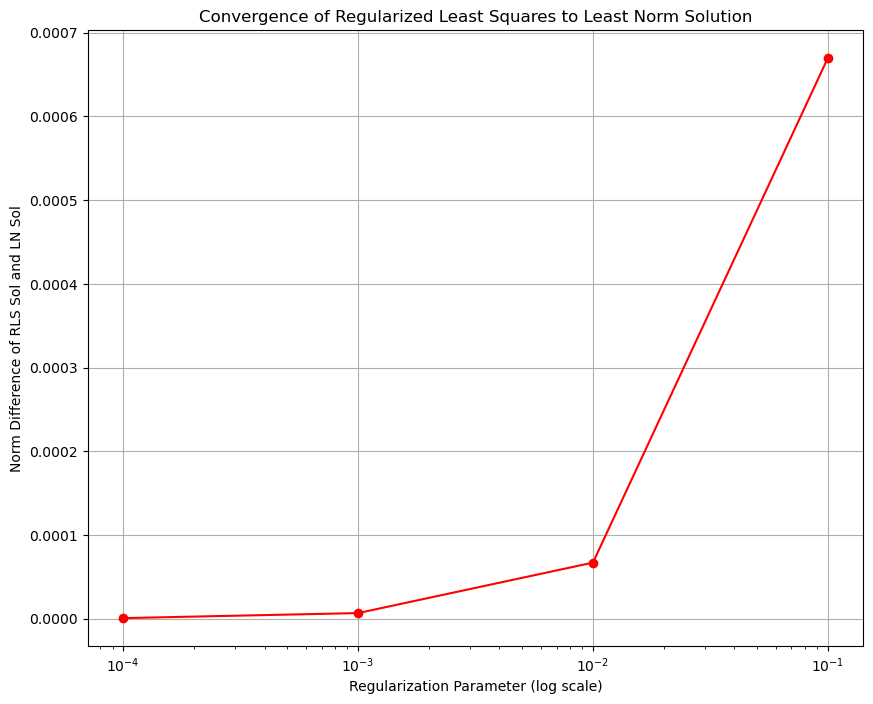

In [13]:
import matplotlib.pyplot as plt


solver = LinearSolver(A, y)
reg_params = [0.1, 0.01, 0.001, 0.0001]

#least norm solution
ln_solution = solver.RLS(reg=0)

norm_differences = []

#regularized least squares solutions 
for r in reg_params:
    rls_solution = solver.RLS(reg = r)
    norm_diff = np.linalg.norm(rls_solution - ln_solution)
    norm_differences.append(norm_diff)


plt.figure(figsize=(10, 8))
plt.plot(reg_params, norm_differences, marker='o', color = 'red')
plt.xscale('log')
plt.xlabel('Regularization Parameter (log scale)')
plt.ylabel('Norm Difference of RLS Sol and LN Sol')
plt.title('Convergence of Regularized Least Squares to Least Norm Solution')
plt.grid(True)
plt.xticks(reg_params)  # Ensure all points are marked on x-axis
plt.show()

## Application 2 (20 pts)

Regularization is a crucial technique in machine learning. In this part, we will show that it can be used to improve machine learning model's performance. The following code generates training and test data.

In [14]:
m = 100         # number of training samples
d = 100         # ambient dimension
A = np.random.normal(0, 1, size=(m,d))             # training data matrix
x_true = np.random.uniform(size=(d,))              # true coefficient vector
y = A@x_true + np.random.normal(0,0.5, size=(m,))  # training labels

m_test = 500    # number of test samples 
A_test = np.random.normal(0,1,size=(m_test,d))     # test data matrix
y_test = A_test @ x_true                           # test labels

Find least square solution without regularization using training data matrix and labels. You should return two quantities:
1. norm of difference between x_true and x_LS, where x_LS is your least square solution
2. mean square error on your prediction. Your prediction can be computed by `A_test @ x_LS`



In [15]:
solver = LinearSolver(A, y)


x_LS = np.linalg.lstsq(A, y, rcond=None)[0]
norm_diff_LS = np.linalg.norm(x_true - x_LS)
pred_LS = A_test @ x_LS
mse_LS = np.mean((pred_LS - y_test) ** 2)


print("Least Squares Solution (No Regularization):")
print("Norm of Difference:", norm_diff_LS)
print("Mean Squared Error on Prediction:", mse_LS)

Least Squares Solution (No Regularization):
Norm of Difference: 7.682977018951909
Mean Squared Error on Prediction: 62.39156737085378


Find regularized least square solution using training data matrix and labels. You should return two quantities:
1. norm of difference between x_true and x_RLS, where x_RLS is your regularized least square solution
2. mean square error on your prediction. Your prediction can be computed by `A_test @ x_RLS`

You should try 3 different regularization parameters and select the best one among your candidates. You should use RLS method in your class.

In [16]:
regularization_params = [0.1, 1, 10]  #parameters for regularization

best_mse = float('inf')
best_param = None
best_x_RLS = None

for r in regularization_params:
    x_RLS = solver.RLS(reg = r)
    norm_diff_RLS = np.linalg.norm(x_true - x_RLS)
    pred_RLS = A_test @ x_RLS
    mse_RLS = np.mean((pred_RLS - y_test) ** 2)
    
    if mse_RLS < best_mse:
        best_mse = mse_RLS
        best_param = r
        best_x_RLS = x_RLS

norm_diff_RLS_best = np.linalg.norm(x_true - best_x_RLS)

print("Best Regularized Least Squares Solution:")
print("Regularization Parameter:", best_param)
print("Norm of Difference:", norm_diff_RLS_best)
print("Mean Squared Error on Prediction:", best_mse)


Best Regularized Least Squares Solution:
Regularization Parameter: 1
Norm of Difference: 1.4073567615888036
Mean Squared Error on Prediction: 2.1013451193978807


Repeat previous steps using SGD method in your class:

Find least square solution without regularization using training data matrix and labels. You should return two quantities:
1. norm of difference between x_true and x_LS, where x_LS is your least square solution
2. mean square error on your prediction. Your prediction can be computed by `A_test @ x_LS`

Find regularized least square solution using training data matrix and labels. You should return two quantities:
1. norm of difference between x_true and x_RLS, where x_RLS is your regularized least square solution
2. mean square error on your prediction. Your prediction can be computed by `A_test @ x_RLS`
You can use the best regularization parameter you have found.

Remark: You may need to try different max_iter, batch_size, and stepsize to achieve acceptable results. You do not need to show how you find them, just state your choices.

In [17]:
max_iter = 1000 
batch_size = 10  
step_size = 0.01

x_LS_SGD = solver.SGD(max_iter=max_iter, b=batch_size, step_size=step_size, reg=0)
norm_diff_LS_SGD = np.linalg.norm(x_true - x_LS_SGD)
pred_LS_SGD = A_test @ x_LS_SGD
mse_LS_SGD = np.mean((pred_LS_SGD - y_test) ** 2)

x_RLS_SGD = solver.SGD(max_iter=max_iter, b=batch_size, step_size=step_size, reg=best_param)
norm_diff_RLS_SGD = np.linalg.norm(x_true - x_RLS_SGD)
pred_RLS_SGD = A_test @ x_RLS_SGD
mse_RLS_SGD = np.mean((pred_RLS_SGD - y_test) ** 2)


print("Least Squares Solution using SGD (No Regularization):")
print("Norm of Difference:", norm_diff_LS_SGD)
print("Mean Squared Error on Prediction:", mse_LS_SGD)

print("\nRegularized Least Squares Solution using SGD:")
print("Regularization Parameter:", best_param)
print("Norm of Difference:", norm_diff_RLS_SGD)
print("Mean Squared Error on Prediction:", mse_RLS_SGD)

Least Squares Solution using SGD (No Regularization):
Norm of Difference: 1.7512172964901154
Mean Squared Error on Prediction: 3.299694597550654

Regularized Least Squares Solution using SGD:
Regularization Parameter: 1
Norm of Difference: 3.63981867297952
Mean Squared Error on Prediction: 13.658233428661804


#### Does your experiment support that regularization is helpful in improving model's performance?

Regularization significantly improved the Regularized LS solution using the explicit formula, while not having a significant impact on the SGD method